In [1]:
pip install kaggle

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cindyz3399","key":"a90282dd0cc53046facead259a1a8adf"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c human-protein-atlas-image-classification

100% 17.5G/17.5G [03:26<00:00, 143MB/s]
100% 17.5G/17.5G [03:28<00:00, 89.9MB/s]


In [6]:
!unzip human-protein-atlas-image-classification.zip -d /content/data/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/data/train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data/train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_green.png  
  inflating: /content/data/train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data/train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data/train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png  
  inflating: /content/data/train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_green.png  
  inflating: /content/data/train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data/train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png  
  inflating: /content/data/train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_blue.png  
  inflating: /content/data/train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_green.png  
  inflating: /content/data/train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_red.png  
  inflating: /content/data/train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.p

In [7]:
import os

data_dir = "/content/data/"
print("File Name:", os.listdir(data_dir))

File Name: ['sample_submission.csv', 'train.csv', 'train', 'test']


In [8]:
print("Train:", len(os.listdir(os.path.join(data_dir, "train"))))
print("Test:", len(os.listdir(os.path.join(data_dir, "test"))))

Train: 124288
Test: 46808


In [9]:
import pandas as pd

train_csv_path = os.path.join(data_dir, "train.csv")
train_labels = pd.read_csv(train_csv_path)

print(train_labels.head())

                                     Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18


In [10]:
import numpy as np

NUM_CLASSES = 28

# One-hot
def multi_label_encoding(labels):
    encoded = np.zeros(NUM_CLASSES, dtype=np.float32)
    for label in labels.split():
        encoded[int(label)] = 1
    return encoded

train_labels['Encoded_Labels'] = train_labels['Target'].apply(multi_label_encoding)

print(train_labels.head())

                                     Id   Target  \
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0   
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0   
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5   
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1   
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18   

                                      Encoded_Labels  
0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  


In [11]:
import torchvision.transforms as transforms
from PIL import Image

# define picture preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_dir = "/content/data/"
train_dir = os.path.join(data_dir, "train")

image_files = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]

if image_files:
    img_path = os.path.join(train_dir, image_files[0])
    image = Image.open(img_path).convert("RGB")
    image = train_transform(image)
    print(image.shape)
else:
    print("No image files found in the train directory.")

torch.Size([3, 224, 224])


In [12]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix

# Data Preperation

In [13]:
data_dir = "/content/data"
train_csv_path = os.path.join(data_dir, "train.csv")
train_images_path = os.path.join(data_dir, "train")

train_labels = pd.read_csv(train_csv_path)
print("training data:", len(train_labels))
print("first lines:\n", train_labels.head())

# Convert Target to a string
train_labels["Target"] = train_labels["Target"].astype(str)

training data: 31072
first lines:
                                      Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18


# Defining a ProteinDataset
Used to load images and tags

In [14]:
class ProteinDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]["Id"]
        labels = self.dataframe.iloc[idx]["Target"]

        # read R/G/B/Y images
        img_red = Image.open(os.path.join(self.img_dir, f"{img_id}_red.png"))
        img_green = Image.open(os.path.join(self.img_dir, f"{img_id}_green.png"))
        img_blue = Image.open(os.path.join(self.img_dir, f"{img_id}_blue.png"))
        img_yellow = Image.open(os.path.join(self.img_dir, f"{img_id}_yellow.png")).convert("L")

        # Convert to tensors
        img_red = transforms.ToTensor()(img_red)
        img_green = transforms.ToTensor()(img_green)
        img_blue = transforms.ToTensor()(img_blue)
        img_yellow = transforms.ToTensor()(img_yellow)

        # Merge into 4 channels
        image = torch.cat([img_red, img_green, img_blue, img_yellow], dim=0)

        # transfer Target to One-hot encoding
        NUM_CLASSES = 28
        encoded_labels = torch.zeros(NUM_CLASSES, dtype=torch.float32)
        for label in str(labels).split():
            encoded_labels[int(label)] = 1

        if self.transform:
            image = self.transform(image)

        return image, encoded_labels

# Preprocessing & training only 1/3 of the data

In [15]:
# Defining Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5])
])

# Create a dataset
train_dataset = ProteinDataset(train_labels, train_images_path, transform=train_transform)

# Pick 1/3 of the data index
subset_size = len(train_dataset) // 3
subset_indices = np.random.choice(len(train_dataset), size=subset_size, replace=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(subset_indices))

for images, labels in train_loader:
    print("Batch image shape:", images.shape)
    print("Batch label sahpe:", labels.shape)
    break


Batch image shape: torch.Size([32, 4, 224, 224])
Batch label sahpe: torch.Size([32, 28])


# Model definition and training
Defining CNNs (DenseNet121, supports 4-channel inputs)

In [16]:
model = models.densenet121(pretrained=True)

model.features.conv0 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 28),
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Use BCELoss as the loss function
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s]


# Train the CNN


In [17]:
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")
print("Training Successful!")

Epoch [1/10], Loss: 0.1972
Epoch [2/10], Loss: 0.1384
Epoch [3/10], Loss: 0.1221
Epoch [4/10], Loss: 0.1067
Epoch [5/10], Loss: 0.0910
Epoch [6/10], Loss: 0.0747
Epoch [7/10], Loss: 0.0565
Epoch [8/10], Loss: 0.0433
Epoch [9/10], Loss: 0.0321
Epoch [10/10], Loss: 0.0244
Training Successful!


# Evaluate the model
Confusion Matrix

In [18]:
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    avg_loss = total_loss / len(dataloader)
    print(f"Test Loss: {avg_loss:.4f}")
    all_preds = torch.cat(all_preds, dim=0).numpy().flatten()
    all_labels = torch.cat(all_labels, dim=0).numpy().flatten()
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

evaluate_model(model, train_loader)


Test Loss: 0.0165
Confusion Matrix:
[[272875    170]
 [  1027  15924]]


However, since this is a highly imbalanced multi-label classification problem (the positive and negative samples are seriously asymmetric), such an evaluation method may be somewhat single. It is suggested that other commonly used indicators for multi-label classification should also be considered to better reflect the performance of the model.

In [27]:
# Additional required imports
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced evaluation function with visualizations
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs > threshold).float()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(dataloader)
    print(f"Test Loss: {avg_loss:.4f}")

    # Flatten predictions and labels
    all_preds_flat = torch.cat(all_preds, dim=0).numpy()
    all_labels_flat = torch.cat(all_labels, dim=0).numpy()

    # Compute confusion matrix for each class separately
    fig, axes = plt.subplots(4, 7, figsize=(20, 12))
    axes = axes.flatten()
    for i in range(NUM_CLASSES):
        cm = confusion_matrix(all_labels_flat[:, i], all_preds_flat[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f"Class {i}")
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    plt.tight_layout()
    plt.show()

    # Generate classification report
    print("Classification Report (Precision, Recall, F1-score):")
    print(classification_report(all_labels_flat, all_preds_flat, target_names=[f"Class {i}" for i in range(NUM_CLASSES)]))

    # ROC Curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(all_labels_flat[:, i], all_preds_flat[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for All Classes')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

Test Loss: 0.0165


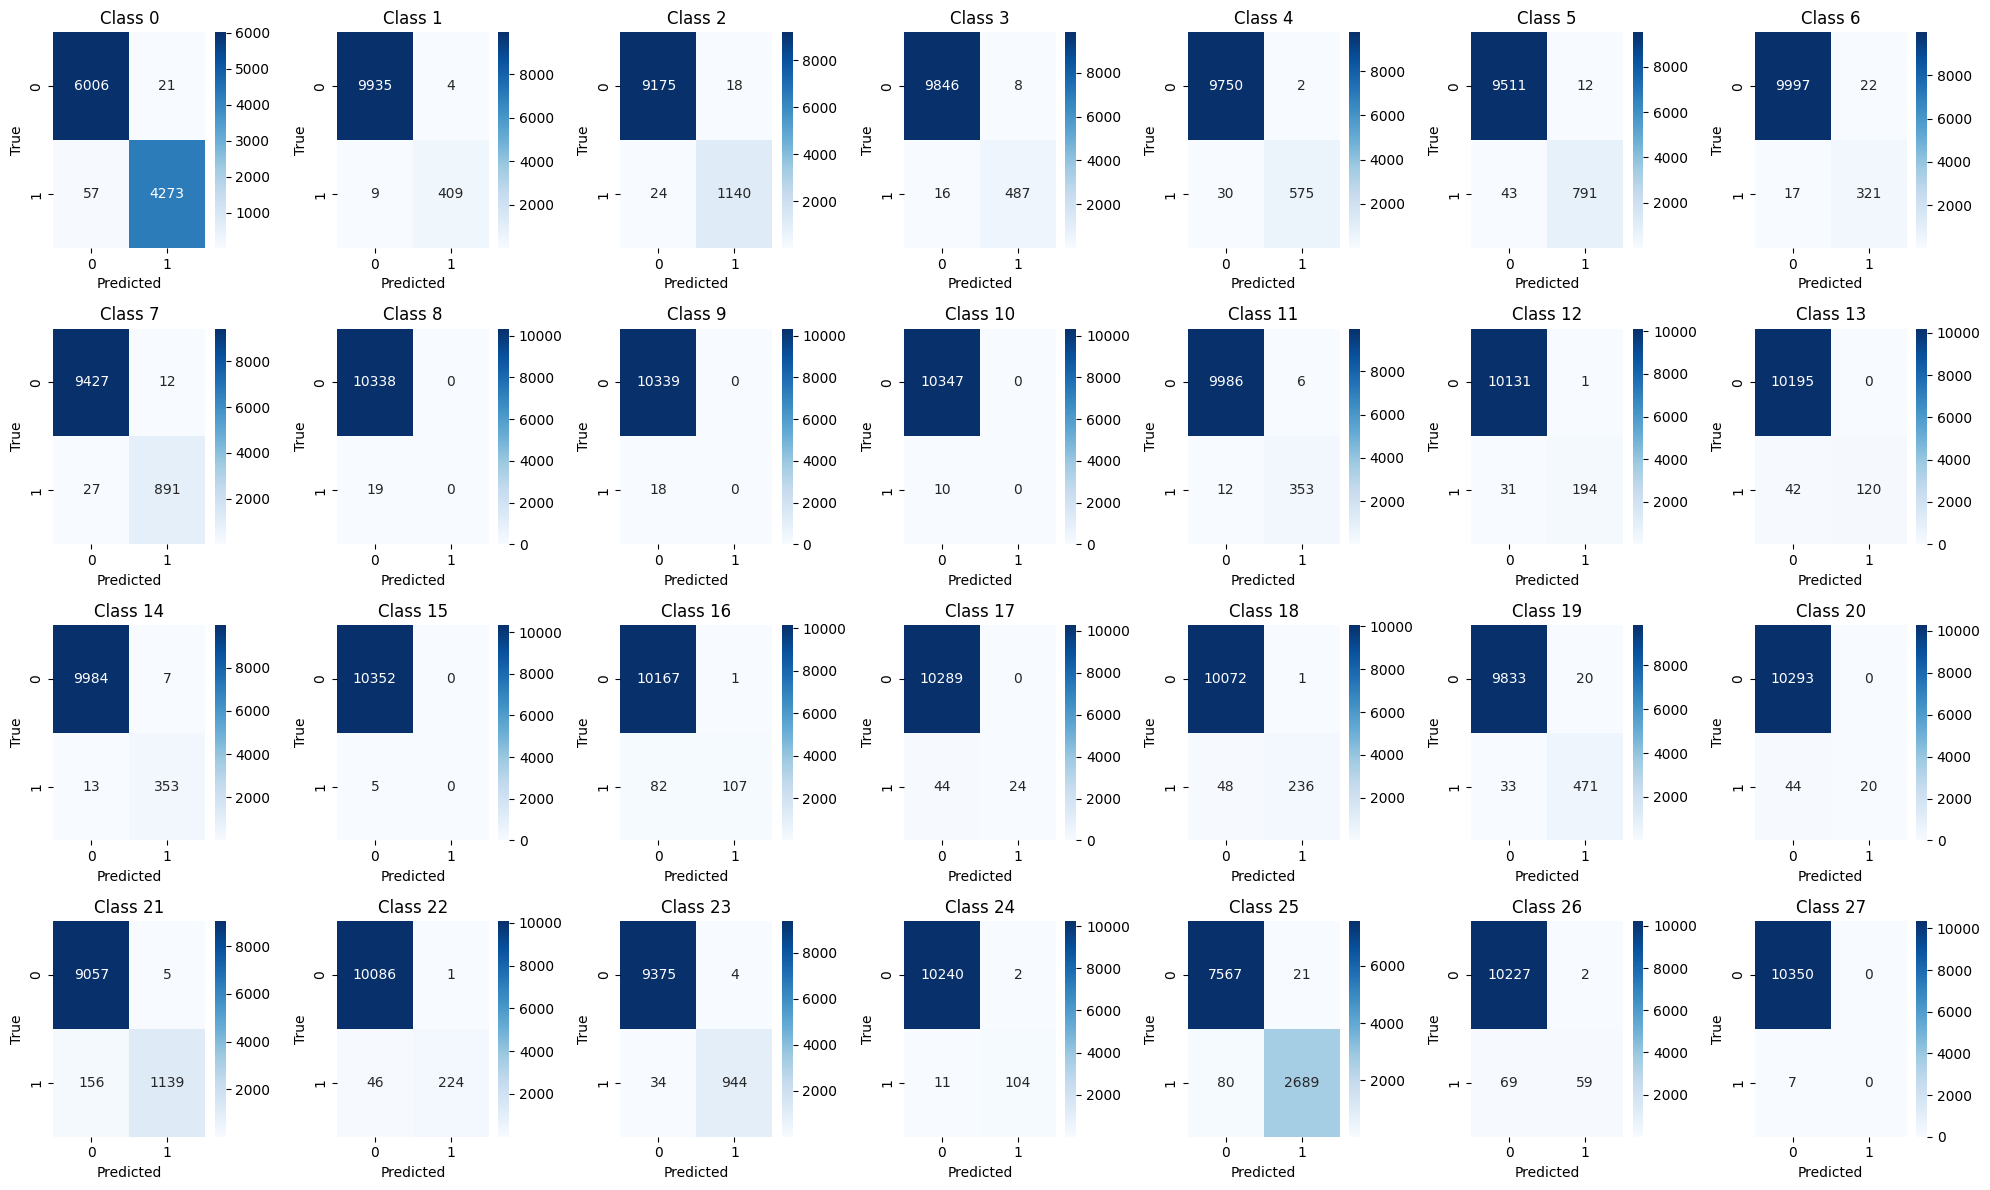

Classification Report (Precision, Recall, F1-score):
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99      4330
     Class 1       0.99      0.98      0.98       418
     Class 2       0.98      0.98      0.98      1164
     Class 3       0.98      0.97      0.98       503
     Class 4       1.00      0.95      0.97       605
     Class 5       0.99      0.95      0.97       834
     Class 6       0.94      0.95      0.94       338
     Class 7       0.99      0.97      0.98       918
     Class 8       0.00      0.00      0.00        19
     Class 9       0.00      0.00      0.00        18
    Class 10       0.00      0.00      0.00        10
    Class 11       0.98      0.97      0.98       365
    Class 12       0.99      0.86      0.92       225
    Class 13       1.00      0.74      0.85       162
    Class 14       0.98      0.96      0.97       366
    Class 15       0.00      0.00      0.00         5
    Class 16       0.99     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


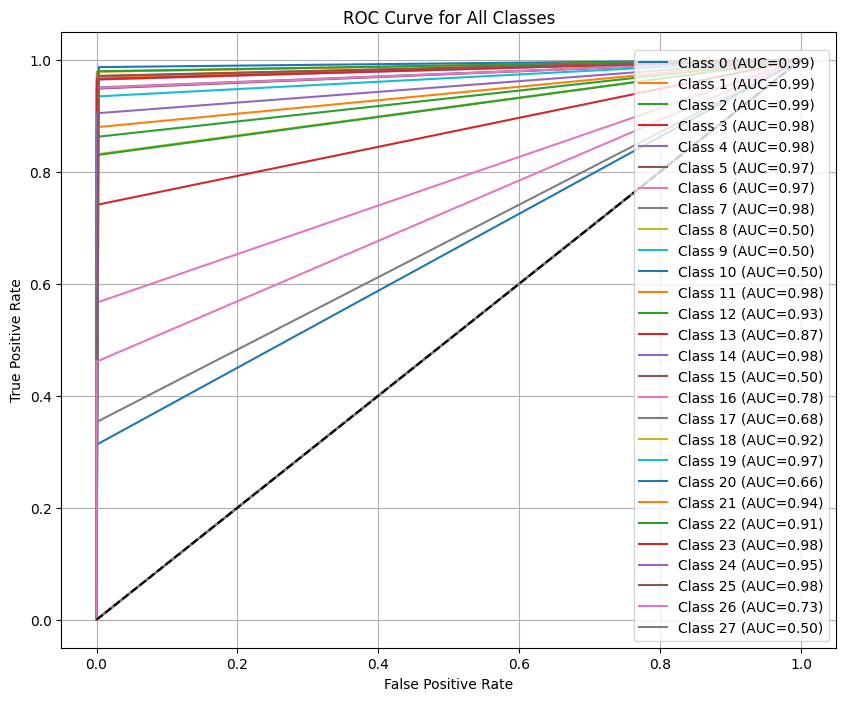

In [28]:
evaluate_model(model, train_loader, threshold=0.5)